Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=CSR, isherm=True
Qobj data =
[[ 0.5  0. ]
 [ 0.  -0.5]]
N: 1, hl_exp: -0.41169408756015075, sql_exp: -0.4116940875601507
Quantum object: dims=[[3], [3]], shape=(3, 3), type='oper', dtype=CSR, isherm=True
Qobj data =
[[ 1.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0. -1.]]
N: 2, hl_exp: 0.7847953827224643, sql_exp: 0.7990446699794217
Quantum object: dims=[[4], [4]], shape=(4, 4), type='oper', dtype=CSR, isherm=True
Qobj data =
[[ 1.5  0.   0.   0. ]
 [ 0.   0.5  0.   0. ]
 [ 0.   0.  -0.5  0. ]
 [ 0.   0.   0.  -1.5]]
N: 3, hl_exp: 1.4657077655686437, sql_exp: 1.496672510984368
Quantum object: dims=[[5], [5]], shape=(5, 5), type='oper', dtype=CSR, isherm=True
Qobj data =
[[ 2.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0. -1.  0.]
 [ 0.  0.  0.  0. -2.]]
N: 4, hl_exp: 1.9046672179239863, sql_exp: 1.9457592513373356
Quantum object: dims=[[6], [6]], shape=(6, 6), type='oper', dtype=CSR, isherm=True
Qobj 

/Users/superman/playground/projects/sensing/qsense/quantum_metrology/utils/metrology.py:36: RuntimeWarning: divide by zero encountered in scalar divide
  delta = 0.5 * np.arctan(B / A)


N: 66, hl_exp: 6.842783374938868, sql_exp: 6.918360409948673
Quantum object: dims=[[68], [68]], shape=(68, 68), type='oper', dtype=CSR, isherm=True
Qobj data =
[[ 33.5   0.    0.  ...   0.    0.    0. ]
 [  0.   32.5   0.  ...   0.    0.    0. ]
 [  0.    0.   31.5 ...   0.    0.    0. ]
 ...
 [  0.    0.    0.  ... -31.5   0.    0. ]
 [  0.    0.    0.  ...   0.  -32.5   0. ]
 [  0.    0.    0.  ...   0.    0.  -33.5]]
N: 67, hl_exp: 6.879910549473088, sql_exp: 6.955532994660211
Quantum object: dims=[[69], [69]], shape=(69, 69), type='oper', dtype=CSR, isherm=True
Qobj data =
[[ 34.   0.   0. ...   0.   0.   0.]
 [  0.  33.   0. ...   0.   0.   0.]
 [  0.   0.  32. ...   0.   0.   0.]
 ...
 [  0.   0.   0. ... -32.   0.   0.]
 [  0.   0.   0. ...   0. -33.   0.]
 [  0.   0.   0. ...   0.   0. -34.]]
N: 68, hl_exp: 6.916659550412372, sql_exp: 6.992326237206985
Quantum object: dims=[[70], [70]], shape=(70, 70), type='oper', dtype=CSR, isherm=True
Qobj data =
[[ 34.5   0.    0.  ...   0.

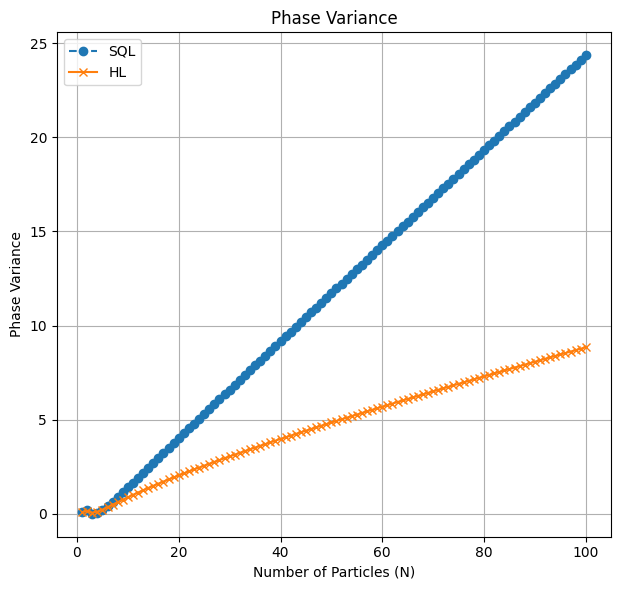

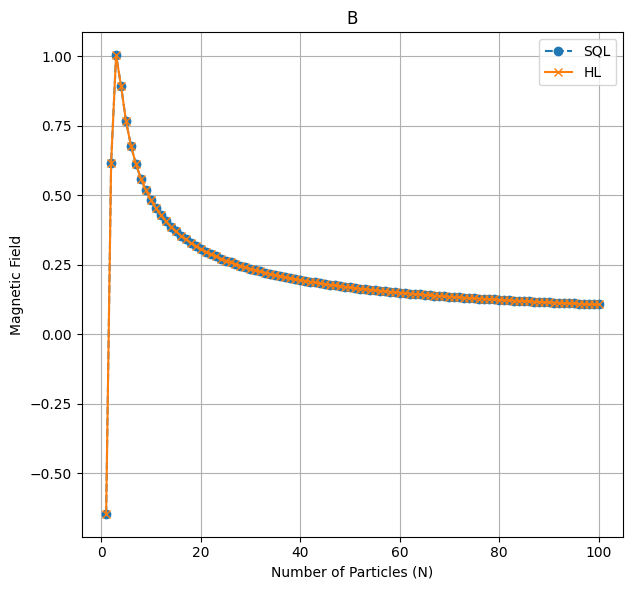

KeyboardInterrupt: 

In [1]:
from quantum_metrology.config import N_MAX, OMEGA, TAU_SENSE, B
from quantum_metrology.utils.metrology import calculate_phase_variances
from quantum_metrology.utils.plotting import plot_results
from quantum_metrology.utils.husimi import compute_husimi_q, plot_husimi_q
# H = omega * tau * Jz
def main():
    # Calculate phase variances and metrological gain
    phase_var_sql, phase_var_hl,  B_sql, B_hl, final_states = calculate_phase_variances(
        N_MAX, OMEGA, B, TAU_SENSE)
    
    plot_results(N_MAX, phase_var_sql, phase_var_hl, B_sql, B_hl, OMEGA, TAU_SENSE)
    j = N_MAX/2
    for state in final_states:
      Q_vals, theta_grid, phi_grid = compute_husimi_q(j, state)
      plot_husimi_q(Q_vals, theta_grid, phi_grid, state_name="State")

if __name__ == "__main__":
    main()